In [1]:
from xgboost import XGBClassifier
import warnings
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from tabpfn_new.scripts.transformer_prediction_interface import TabPFNClassifier, MedPFNClassifier
from tabpfn_new.scripts.model_builder import load_model
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
from load_models import *
import matplotlib.pyplot as plt
import torch
import openml
import time
#pd.set_option('display.expand_frame_repr', False)

In [20]:
path = "datasets/data_all.csv"
all_data, labels = get_microbiome(path)
all_data = remove_zero_features(all_data)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=42)

In [25]:
save = False
sampling = None
cv = 7
best_delete = 0
strat_split = True
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 3
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
run_name = "medium_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
filename = "model"

#all_data = all_data+1e-10
#all_data = np.log(all_data)-np.mean(np.log(all_data), axis=0)
#all_data = (all_data-np.mean(all_data,axis=0))/(np.std(all_data,axis=0)+1e-10)
models = [
    #CatBoostOptim(n_optim=cat_optim),
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #MedPFNClassifier(base_path=path2, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #XGBoostOptim(n_optim=n_optim),
    LogisticRegression(max_iter=1000), 
    #TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
]

for reducer in [AnovaSelect()]:#, RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete)

    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = reducer.__class__.__name__
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters


C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\

Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Transformer with 6.48 M parameters
Using style prior: True
Using cpu:0 device
Using a Tra

C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenna\anaconda3\


 
 AnovaSelect 
                         accuracy mean  accuracy std  precision mean  \
MajorityClass                   0.939         0.000           0.000   
XGBClassifier                   0.947         0.005           0.586   
MedPFNClassifier                0.939         0.004           0.503   
MedPFNClassifier                0.928         0.004           0.439   
RandomForestClassifier          0.955         0.003           0.820   
LogisticRegression              0.939         0.000           0.000   

                        precision std  recall mean  recall std  roc_auc mean  \
MajorityClass                   0.000        0.000       0.000         0.500   
XGBClassifier                   0.055        0.430       0.047         0.705   
MedPFNClassifier                0.027        0.570       0.028         0.767   
MedPFNClassifier                0.021        0.626       0.032         0.787   
RandomForestClassifier          0.069        0.346       0.018         0.670   
Logi

C:\Users\lenna\anaconda3\envs\master4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
save = True
sampling = None
cv = 7
best_delete = 0
strat_split = True
n_optim = 1000
cat_optim = 10
ft_epochs = 15
ft_lr = 1e-7
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 7
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
run_name = "medium_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
models = [
    #CatBoostOptim(n_optim=cat_optim),
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
    #                ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #XGBoostOptim(n_optim=n_optim),
    LogisticRegression(max_iter=1000), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
]

for reducer in [AnovaSelect()]:#, RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
    for std in [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4]:
        print("\n\n", std)
        noise_data = all_data + np.abs(np.random.default_rng(seed=42).normal(0,std,size=all_data.shape))
        results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                    index=[m.__class__.__name__ for m in models],
                                    columns=metrics+["runtime"])
        results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                                   index=[m.__class__.__name__ for m in models],
                                   columns=metrics+["runtime"])
        
        for ii, model in enumerate(models):
            results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
                model, noise_data, labels, metrics, strat_split, cv, sampling, 
                reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete)
    
        results_mean = results_mean.add_suffix(" mean")
        results_std = results_std.add_suffix(" std")
        results_full = pd.concat((results_mean, results_std), axis=1)
        cols = results_full.columns.tolist()
        new_cols = []
        for i in range(int(len(cols)/2)):
            new_cols.append(cols[i])
            new_cols.append(cols[i+int(len(cols)/2)])
        results_full = results_full[new_cols]
        red_name = "noise"
        if save:
            directory = f"results/{red_name}"
            if not os.path.exists(directory):
                os.makedirs(directory)
            save_path = f'results/{red_name}/n{std}_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}'
            results_full.to_csv(save_path)
        #print("\n", "\n", red_name, "\n", results_full.round(3))
        print(results_full.sort_values("roc_auc mean").round(3))

In [ ]:
save = True
sampling = None
cv = 7
best_delete = 0
strat_split = True
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_lr = 1e-7
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 7
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
run_name = "medium_mlp_var_balance_05weight_anova" ### BEST!!!!!! ####
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
models = [
    #CatBoostOptim(n_optim=cat_optim),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    RandomForestClassifier(),
    #XGBoostOptim(n_optim=n_optim),
    LogisticRegression(max_iter=1000), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
]

#for reducer in [AnovaSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
reducer = AnovaSelect()
#for reduce_data in [top_anova, top_non_zero, top_mean, top_std, top_max, pca_reduce]:
    #data = reduce_data(all_data, labels, 100)
    #print(all_data.shape)
for best_delete in range(0,510,10):
    #reducer.k = 100
    #reducer = None
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete)

    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = "feature_select_shift_10step"
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/{best_delete}_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))

In [18]:
all_data = []
all_labels = []
for p in ["datasets/CRC_AUS_LOSO.csv", 
          "datasets/CRC_FRA_LOSO.csv",
         "datasets/CRC_CHI_LOSO.csv",
         "datasets/CRC_GER_LOSO.csv",
         #"datasets/CRC_IND_additional.csv",
         "datasets/CRC_USA_LOSO.csv"]:
    df = pd.read_csv(p)
    df_binary = df.loc[(df["disease"] == "healthy") | (df["disease"]=="CRC")]
    df_data = df_binary.iloc[:,4:]
    data = df_data.to_numpy()
    labels = df_binary["disease"].to_numpy()
    labels[labels=="healthy"] = 0
    labels[labels=="CRC"] = 1
    data = (1/np.sum(data, axis=1, keepdims=True))*data
    all_data.append(data)
    all_labels.append(labels)

all_data = np.concatenate(all_data,axis=0)
labels = np.concatenate(all_labels)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=412)
c1_ind = (labels==1).nonzero()[0]
c1_del = c1_ind[:int(len(c1_ind)*0.97)]
all_data, labels = np.delete(all_data, c1_del, axis=0), np.delete(labels, c1_del, axis=0)

<Figure size 2400x600 with 0 Axes>

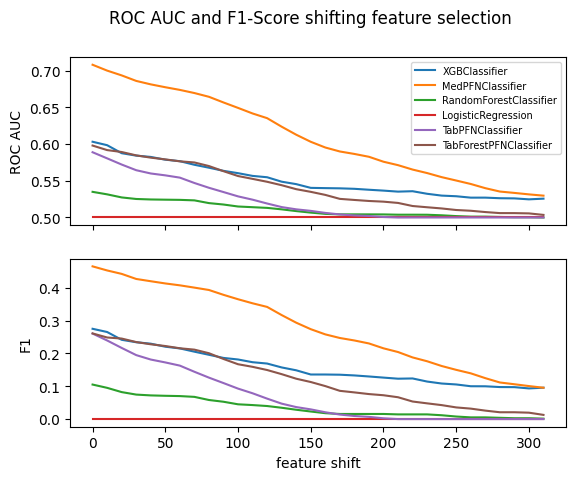

In [4]:
ws = 20
rocs = []
f1s = []
for i in range(0,510,10):
    results = pd.read_csv(f'results/feature_select_shift_10step/{i}_cv{7}_mxsamp{1024}_sd{42}_ovrw{1}')
    rocs.append(results["roc_auc mean"].values)
    f1s.append(results["f1 mean"].values)
rocs = np.array(rocs)
f1s = np.array(f1s)
labels = results.iloc[:,0].values
plt.figure(figsize=(12,3), dpi=200)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
colors = []
for cl in range(rocs.shape[1]):
    ax1.plot(np.arange(rocs.shape[0]-ws+1)*10, moving_average(rocs[:,cl], ws), label=labels[cl])
    ax2.plot(np.arange(rocs.shape[0]-ws+1)*10, moving_average(f1s[:,cl], ws), label=labels[cl])
plt.suptitle("ROC AUC and F1-Score shifting feature selection")
#ax1.set_title("ROC AUC")
ax1.set_ylabel("ROC AUC")
#ax2.set_title("F1-Score")
ax2.set_xlabel("feature shift")
ax2.set_ylabel("F1")
ax1.legend(fontsize=7)
plt.show()

In [ ]:
counts = np.count_nonzero(all_data, axis=0)
counts = 1-counts/all_data.shape[0]
means = np.mean(all_data, axis=0)
plt.scatter(counts, means, s=1)
plt.show()
plt.scatter(counts, np.max(all_data, axis=0), s=1)

In [ ]:
print(error)

In [ ]:
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
run_name = "medium_net_mlp_balance_bsplit_baseline_longer"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
for sampling in [None]:#, undersample]:
    cv = 5
    strat_split = True
    n_optim = 1000
    cat_optim = 10
    ft_epochs = 10
    ft_lr = 1e-8
    max_s = 1024
    max_q = 128
    max_samples = None
    no_pre_process = False
    multi_decoder = None
    N_ens = 5
    metrics = ["accuracy", "precision", "recall", "roc_auc"]
    models = [
        #CatBoostOptim(n_optim=cat_optim),
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder, ft_epochs=ft_epochs, ft_lr=ft_lr,
        #                 max_s=max_s, max_q=max_q, no_preprocess_mode=no_pre_process),
        MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=5, no_preprocess_mode=True),
        XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
        XGBoostOptim(n_optim=n_optim),
        LogisticRegression(max_iter=500), 
        TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
        TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
    ]
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(model, data, labels, metrics, strat_split, cv, sampling, max_samples)
    #results_sorted = results.sort_values("roc_auc")
    #print(results_sorted)
    print(results_mean)
    print(results_std)

In [ ]:
cols = []
for m in metrics + "runtime":
    cols.append(m)
    cols.append(m+" std")

In [ ]:

dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
#model, config = load_model(path, filename, device="cpu", eval_positions=None, verbose=0)
#pred_model = TabPFNClassifier(model[2], config, device="cpu", N_ensemble_configurations=5, no_preprocess_mode=False)
for sampling in [None]:
    cv = 3
    strat_split = True
    n_optim = 10
    ft_epochs = 10
    max_samples = None
    metrics = metrics = ["accuracy", "precision", "recall", "roc_auc"]
    models = [
        RandomForestClassifier()
        #CatBoostOptim(n_optim=n_optim),
        #pred_model,
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=3, no_preprocess_mode=True),
        #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
        #XGBoostOptim(n_optim=n_optim),
        #LogisticRegression(max_iter=500), 
        #TabPFNClassifier(device='cpu', N_ensemble_configurations=3, no_preprocess_mode=True),
        #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
    ]
    results = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                          columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results.iloc[ii,:] = cross_validate_sample(model, data, labels, metrics, strat_split, cv, sampling, max_samples)
    results_sorted = results.sort_values("roc_auc")
    
    print(results_sorted)

In [ ]:
print(results_sorted)